# Measuring SNR of an Audio Sample

In order to quantify our demodulator, we need to measure the SNR of
baseband signals.

If we don't have a pristine copy of the baseband, we have to estimate
the noise by finding pure noise, one completely free of the signal,
either in the time domain or in the frequency domain to use as a base
for the noise estimate.

This post discusses one way to do this.

https://dsp.stackexchange.com/questions/35403/calculate-the-snr-of-wav-file

This is the formula that they suggest.

$ SNR=\frac{P(signal)+P(noise)-P(noise)}{P(noise)} $

For M17, the 4-FSK baseband is restricted to 3500Hz and below.  Here the spectrum
of a -121dBm signal from a vector signal generator into an RTL SDR running `rtl_fm`.

![M17 Baseband](m17-baseband-spectrum.png)

In [1]:
%pylab inline

import cmath
import numpy as np
import scipy.io.wavfile
from scipy.signal import firwin, lfilter, lfilter_zi

Populating the interactive namespace from numpy and matplotlib


# Notes

In an earlier version of the document we explored analyzing the signal using a
DFT.  The expectation was we could sample a segment of the in-band signal and a
segment of the out-of-band signal to derive the SNR.  But that turned out to
be inaccurate.  In order to get an accurate measure, we needed to sample essentially
all of the bins.  And for that a simple DFT is too slow.

What we endded up doing is measuring the power spectral density and using that
to estimate SNR.  There are much better tools available, especially in `scipy.signal`,
for measuring PSD.

Computing the SNR is fairly straight-forward, but I needed to refer to this
SINAD code to understand how to handle PSD properly when calculating SNR.

https://github.com/scivision/gnuradio_ham/blob/main/sinad.py#L68

# Power Spectral Density

We need to measure the power spectral density of the baseband signal.  We will
do that by generating a spectrogram and then averaging the individial time
slices.

We are going to make some simplifying assumptions in the code below.  We are
sampling the baseband at 48000Hz.  The M17 signal is from 0-2400Hz.  There is
some roll-off from 2400Hz to 3500Hz.  The noise is in bins from 3500Hz and above.

## Plotting Functions

Let's define a function that will compute the PSD, optionally graph the signal
information, and return the SNR.

In [2]:
from scipy.signal import periodogram, welch, spectrogram
from matplotlib.colors import LogNorm

def compute_snr(baseband, plot=True):
    
    # Generate the spectrogram (a time series of FFTs)
    f, t, S = spectrogram(baseband, fs = 48000, nfft = 2400, window='hamming')
    # Average all the FFTs to get the PSD.
    Pxx_den = np.mean(S, axis=1)

    if plot:
        plt.rcParams['figure.figsize'] = [8, 6]

        duration = .001
        tm = np.linspace(0, duration, 480, endpoint=True)

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

        ax1.set_ylabel('Amplitude')
        ax1.locator_params(axis='y', nbins=8)
        ax1.grid()
        ax1.set_xticks(np.arange(0, duration, 1.0/4800))
        ax1.plot(tm, baseband[4000:4480], '-')

        ax2.pcolormesh(t, f, S, shading='gouraud', norm=LogNorm(np.min(S), np.max(S)))
        ax2.set_ylabel('Frequency [Hz]')
        ax2.set_xlabel('Time [sec]')

        ax3.semilogy(f, Pxx_den)
        ax3.set_xlabel('frequency [Hz]')
        ax3.set_ylabel('PSD [V**2/Hz]')

    signal = np.sum(Pxx_den[0:245])
    noise = np.mean(Pxx_den[350:])
    snr = 10 * log10((signal - (noise * 245))/(noise * len(Pxx_den)))
    return snr

## Analysis

We are now going to measure a file -- the same file from the plot above.

Note that there are files with captured at 120-123dBm, inclusive in the
directory.  You can just change the dBm value in the filename to
analyze those files.

2.8760447483954583


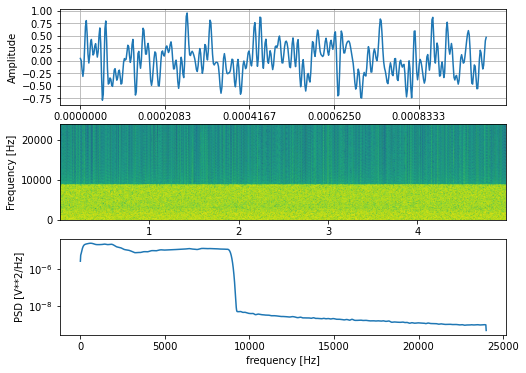

In [3]:
sample_rate, testdata = scipy.io.wavfile.read('test-122dBm.wav')

# Remove the noise at the start of the file and normalize the signal.
testdata = testdata[96000:48000*7] / 32768.0

snr = compute_snr(testdata)
print(snr)

## SNR to Eb/N0

We will need to convert the SNR value to Eb/NO (energy per bit to noise power
spectral density ratio).  The formula for this is:

$ E_b/N_0 = {SNR}{\frac{B_{Hz}}{f_b}} $

Where $f_b$ is the information rate and $B_{Hz}$ is the channel bandwidth.

For M17, we have a $B_{Hz}$ of roughly 8900Hz.  The information rate, $ f_b $,
is a little more difficult.  The information rate of each of the frame types,
the link setup frame, the audio stream frame, the packet frame, and the LICH,
are all different.  We are going to focus on just the audio frame for now.

The audio frame use a punctured 1:2 convolutional code to acheive a rate 6:11.
at 9600 bits per second, that equates to an $ f_b $ of 5236.

Here is the computed SNR and Eb/N0

In [4]:
def compute_EbN0(snr):
    
    return snr * (8900.0 / 5236.0)
    
EbN0 = compute_EbN0(snr)
print(f'SNR = {snr:3.2f}, Eb/N0 = {EbN0:3.2f}dB')

SNR = 2.88, Eb/N0 = 4.89dB


## Simulation

We need to show that the above works properly by taking a pure baseband signal and adding
AWGN to it.  This will give us a known SNR value and allows us to verify that the above
SNR analysis is correct.

To do that we define functions that will add AWGN to an M17 baseband file to acheive a
specified SNR.

 - https://stackoverflow.com/questions/52913749/add-random-noise-with-specific-snr-to-a-signal
 - https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python
 - https://medium.com/analytics-vidhya/adding-noise-to-audio-clips-5d8cee24ccb8

In [5]:
def add_awgn(signal, SNR_dB):
    """Add noise to a signal to acheive the specified SNR (in dB), returning the
    noisy signal and the noise that was added to the signal."""
    
    snr = 10.0**(SNR_dB/10.0)
    power = signal.var()
    noise = np.random.normal(0, np.sqrt(power / snr), len(signal))
    return signal+noise, noise

def load_noisy(filename, SNR_dB):
    """Returns the sample rate of the file, the signal plust noise, and the noise
    that was added to the signal."""
    
    sample_rate, baseband_data = scipy.io.wavfile.read(filename)
    baseband_data = np.array(baseband_data, dtype=float) / 32768.0
    return sample_rate, *add_awgn(baseband_data, SNR_dB)

Let's load a file with 6dB of AWGN and plot the clean and noisy versions of the waveform.

The file we are using was created by taking the raw baseband output from `m17-mod` and
converting it to a WAV file.  It is as noise-free as possible.

In [6]:
sps, clean = scipy.io.wavfile.read('m17-brain.wav')
clean = np.array(clean, dtype=float) / 32768.0
noisy_brain, noise = add_awgn(clean, 6.0)
scipy.io.wavfile.write('m17-brain-6dB.wav', sps, np.array(
    np.concatenate([noise * 2, noisy_brain * .75]), dtype=np.int16))

And now let's analyze the file, plot the spectrum and show the SNR and Eb/N0.

The computation may take some time.

SNR = 5.83, Eb/N0 = 9.90dB


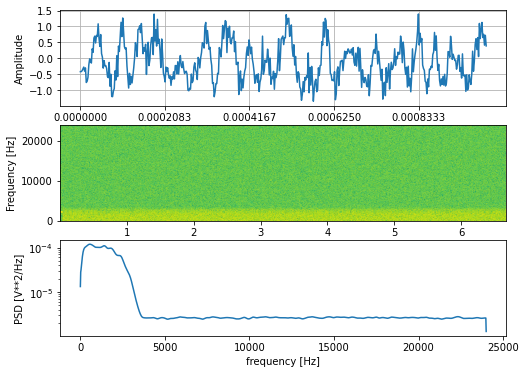

In [7]:
snr  = compute_snr(noisy_brain, 24000)
EbN0 = compute_EbN0(snr)
print(f'SNR = {snr:3.2f}, Eb/N0 = {EbN0:3.2f}dB')

This is within 0.15dB of what we expect.  Let's try a few more to see if the results hold up.

SNR = 2.82, Eb/N0 = 4.78dB


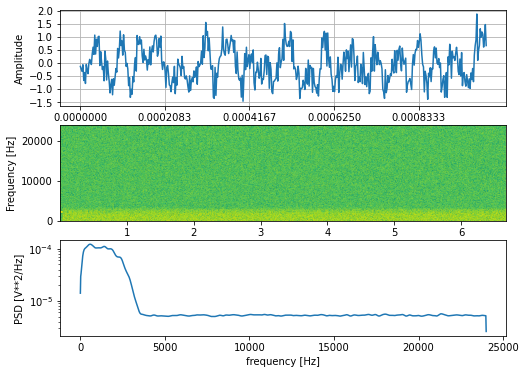

In [8]:
sps, n3dB, noise = load_noisy('m17-brain.wav', 3.0)
snr = compute_snr(n3dB)
EbN0 = compute_EbN0(snr)
print(f'SNR = {snr:3.2f}, Eb/N0 = {EbN0:3.2f}dB')

That's interesting.  It is low by the exact same 0.15dB as the 6dB sample.  Let's try a higher SNR.

SNR = 11.83, Eb/N0 = 20.11dB


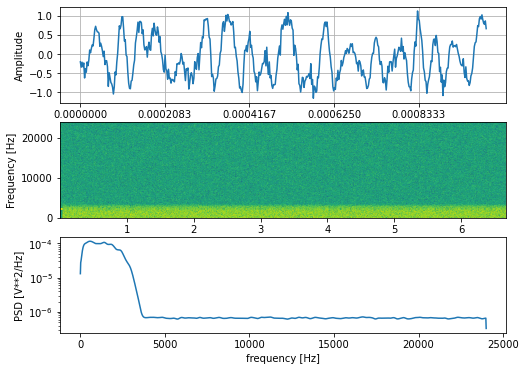

In [9]:
sps, n12dB, noise = load_noisy('m17-brain.wav', 12.0)
snr = compute_snr(n12dB)
EbN0 = compute_EbN0(snr)
print(f'SNR = {snr:3.2f}, Eb/N0 = {EbN0:3.2f}dB')

This shows as similarly close SNR.

# Summary

This shows that the measurement of SNR, if the AWGN code is accurate, does work
relatively well.  The SNR values are off by a fraction of a dB.  This allows us
to measure the SNR and Eb/N0 of a captured M17 baseband fairly accurately.